## [02] Augmentation comparison


### rubric
1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가? CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.

2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가? Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함

3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

### 실습목표

- Augmentation을 모델 학습에 적용하기
- Augmentation의 적용을 통한 학습 효과 확인하기
- 최신 data augmentation 기법 구현 및 활용하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## part1. 데이터 불러오기

In [ ]:
# TensorFlow and tf.keras


import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Dataset

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True, # dict 형태가 아닌 tuple 형태로 데이터를 return 
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


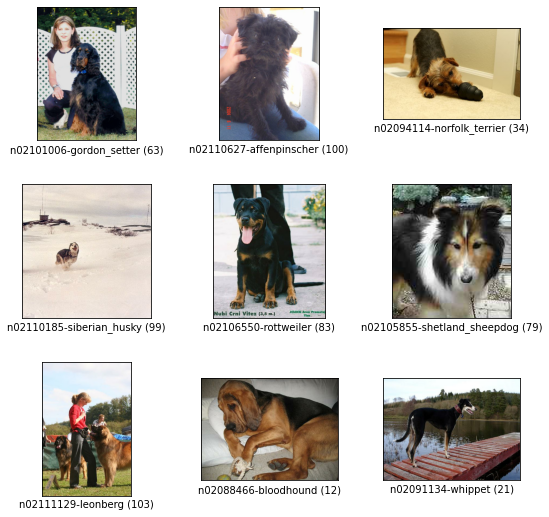

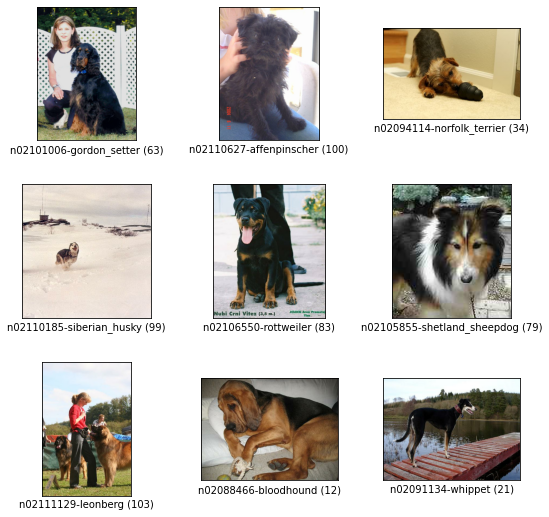

In [ ]:
tfds.show_examples(ds_train, ds_info)

## part2. Augmentation 

텐서플로우 Random Augmentation API 사용하기
많은 augmentation 기법들이 있지만 그중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해 보겠습니다. 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같습니다.

- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

In [ ]:
# 전처리함수 format

# def 전처리_함수(image, label):   # 변환할 이미지와 라벨
    # 이미지 변환 로직 적용
    # new_image = 이미지_변환(image)
    # return new_image, label

In [ ]:
# 기본적인 전처리 함수

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224]) # resize 까먹지 말기!
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) # flip 좌우대칭 
    image = tf.image.random_brightness(image, max_delta=0.2) # brightness 조절
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


In [ ]:
# 데이터셋을 가공하는 메인함수


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

### (1) Augmentation: Cutmix

1) 이미지 섞기

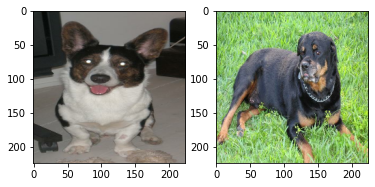

In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(85, shape=(), dtype=int32)
y :  tf.Tensor(62, shape=(), dtype=int32) tf.Tensor(195, shape=(), dtype=int32)


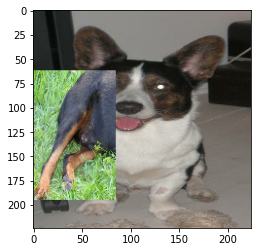

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

2) 라벨 섞기

In [ ]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


### (2) Augmentation: Mixup 

In [ ]:
num_classes = ds_info.features['label'].num_classes

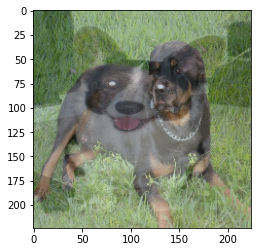

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.46779466
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [ ]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
# aug를 적용할 수 있도록 변환한 apply_normalize_on_dataset() 
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝💨')

슝💨


## part3. model building

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('슝💨')

슝💨


In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94781440/94765736 [==============================] - 1s 0us/step
=3


In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('슝💨')

슝💨


In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('슝💨')

슝💨


In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('슝💨')

슝💨


## part4. model training

In [ ]:
# epoch 최소를 20으로 잡음
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 108s 121ms/step - loss: 2.2251 - accuracy: 0.4386 - val_loss: 3.3795 - val_accuracy: 0.2037
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.6855 - accuracy: 0.8123 - val_loss: 1.0669 - val_accuracy: 0.6842
Epoch 3/20
750/750 [==============================] - 92s 122ms/step - loss: 0.1983 - accuracy: 0.9628 - val_loss: 0.9010 - val_accuracy: 0.7294
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0522 - accuracy: 0.9960 - val_loss: 0.8771 - val_accuracy: 0.7403
Epoch 5/20
750/750 [==============================] - 90s 119ms/step - loss: 0.0207 - accuracy: 0.9998 - val_loss: 0.8926 - val_accuracy: 0.7392
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.9021 - val_accuracy: 0.7395
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.9114 - val_a

In [ ]:
history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 98s 119ms/step - loss: 2.2921 - accuracy: 0.4297 - val_loss: 3.0512 - val_accuracy: 0.2501
Epoch 2/20
750/750 [==============================] - 93s 124ms/step - loss: 0.9179 - accuracy: 0.7377 - val_loss: 1.5349 - val_accuracy: 0.5695
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.5307 - accuracy: 0.8527 - val_loss: 1.2467 - val_accuracy: 0.6386
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2732 - accuracy: 0.9327 - val_loss: 1.0561 - val_accuracy: 0.6958
Epoch 5/20
750/750 [==============================] - 90s 119ms/step - loss: 0.1938 - accuracy: 0.9565 - val_loss: 1.0808 - val_accuracy: 0.7045
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1562 - accuracy: 0.9661 - val_loss: 1.0467 - val_accuracy: 0.7160
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0610 - accuracy: 0.9912 - val_loss: 0.9476 - val_ac

In [ ]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 101s 122ms/step - loss: 3.8356 - accuracy: 0.2074 - val_loss: 3.4187 - val_accuracy: 0.1990
Epoch 2/20
750/750 [==============================] - 90s 121ms/step - loss: 2.9449 - accuracy: 0.4319 - val_loss: 1.7152 - val_accuracy: 0.5321
Epoch 3/20
750/750 [==============================] - 90s 121ms/step - loss: 2.6469 - accuracy: 0.5282 - val_loss: 1.2926 - val_accuracy: 0.6434
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 2.4481 - accuracy: 0.5931 - val_loss: 1.2695 - val_accuracy: 0.6495
Epoch 5/20
750/750 [==============================] - 95s 127ms/step - loss: 2.2874 - accuracy: 0.6443 - val_loss: 1.1389 - val_accuracy: 0.6890
Epoch 6/20
750/750 [==============================] - 90s 121ms/step - loss: 2.1630 - accuracy: 0.6870 - val_loss: 1.1631 - val_accuracy: 0.6834
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 2.0523 - accuracy: 0.7187 - val_loss: 1.3064 - val_a

In [ ]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 100s 121ms/step - loss: 3.7070 - accuracy: 0.2488 - val_loss: 3.6411 - val_accuracy: 0.1595
Epoch 2/20
750/750 [==============================] - 90s 120ms/step - loss: 2.8364 - accuracy: 0.4857 - val_loss: 1.8145 - val_accuracy: 0.5028
Epoch 3/20
750/750 [==============================] - 95s 127ms/step - loss: 2.5539 - accuracy: 0.5947 - val_loss: 1.3091 - val_accuracy: 0.6374
Epoch 4/20
750/750 [==============================] - 90s 120ms/step - loss: 2.3712 - accuracy: 0.6588 - val_loss: 1.2318 - val_accuracy: 0.6580
Epoch 5/20
750/750 [==============================] - 90s 120ms/step - loss: 2.2742 - accuracy: 0.6975 - val_loss: 1.2166 - val_accuracy: 0.6673
Epoch 6/20
750/750 [==============================] - 90s 121ms/step - loss: 2.1314 - accuracy: 0.7523 - val_loss: 1.1946 - val_accuracy: 0.6722
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 2.0588 - accuracy: 0.7814 - val_loss: 1.2095 - val_a

## part5. training process visualization

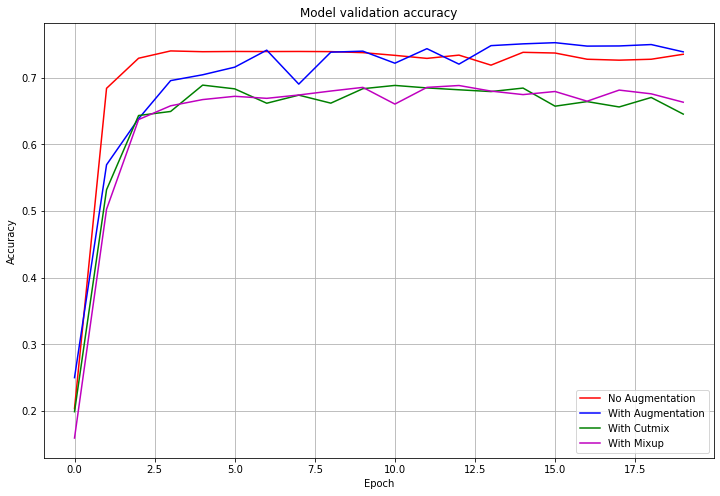

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50 .history['val_accuracy'], 'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

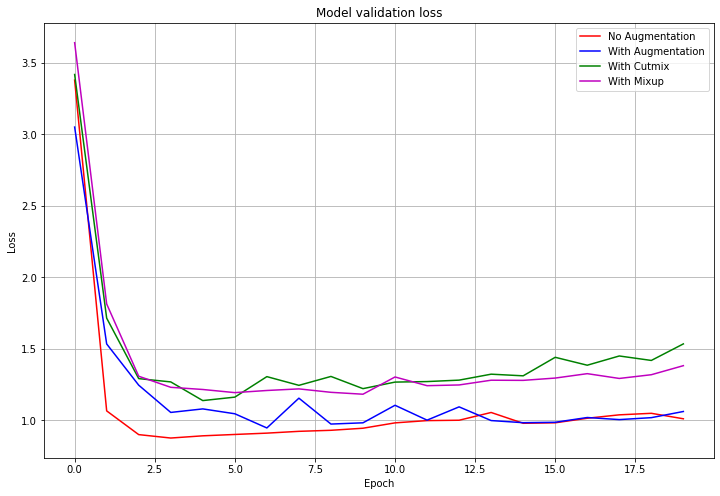

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history_resnet50.history['val_loss'], 'r')
plt.plot(history_aug_resnet50.history['val_loss'], 'b')
plt.plot(history_cutmix_resnet50 .history['val_loss'], 'g')
plt.plot(history_mixup_resnet50.history['val_loss'], 'm')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

## part6. Augmentation에 의한 모델 성능 비교

In [ ]:
# import pandas as pd

# accuracy_data = {'resnet50': resnet50.history['val_accuracy'],
               #   'Augmentation': history_aug_resnet50.history['val_accuracy'],
               #   'CutMix': history_cutmix_resnet50 .history['val_accuracy'],
               #   'MixUp': history_mixup_resnet50.history['val_accuracy']   
# }

# accuracy_df = pd.DataFrame(accuracy_data)
# accuracy_df[-5:]

In [ ]:
# accuracy_df.describe()

### trial and error

쉬운 파트여서 빠르게 끝냈고 비교도 어렵지 않았다. 초반에 커널 설정 잘못해서 그냥 돌리다가 시간이 너무 안가서 보니 gpu를 쓰지 않았다는 걸 알아채곤 약간 절망했지만 acc도 loss도 너무 잘 나와줘서 힘이 하나도 안들었다. 이제 어느정도 익숙해진 것 같은 CV